<h1 style="padding: 25px 25px; background-color: #F5B041; font-family: Sans-Serif; color:black; text-align: center">
Data Exploration</h1>

In [ ]:
pip install ultralytics

In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from IPython.core.magic import register_line_cell_magic
import yaml
from PIL import Image
import os
import seaborn as sns
from ultralytics import YOLO
from matplotlib.patches import Rectangle
import glob
import cv2

In [3]:
warnings.filterwarnings("ignore")

np.random.seed(12345)

%matplotlib inline

!wandb disabled

/bin/bash: wandb: command not found


In [4]:
INPUT_DIR = '/home/raza.imam/Documents/FRC/YOLOv8/datasets/Camel-object-detection-MAIN-2'
WORK_DIR = '/home/raza.imam/Documents/FRC/YOLOv8/datasets/Camel-object-detection-MAIN-2'

<a id="Data Exploration"></a>
<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Data Exploration</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Create data YAML file</b></h4>

In [5]:
num_classes = 4
classes = ['camel', 'mask', 'pole', 'rope']

In [6]:
dict_file = {'train': os.path.join(INPUT_DIR, 'train'),
             'val': os.path.join(INPUT_DIR, 'valid'),
             'test': os.path.join(INPUT_DIR, 'test'),
             'nc': num_classes,
             'names': classes
            }

with open(os.path.join(WORK_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check class balance</b></h4>

In [7]:
class_idx = {str(i):classes[i] for i in range(num_classes)}

class_stat = {}
data_len = {}

for mode in ['train', 'valid', 'test']:

    class_count = {classes[i]:0 for i in range(num_classes)}

    path = os.path.join(INPUT_DIR, mode, 'labels')

    for file in os.listdir(path):

        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1
                
    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

In [8]:
data_len

{'train': 2035, 'valid': 300, 'test': 151}

In [9]:
class_stat

{'train': {'camel': 2015, 'mask': 1678, 'pole': 1901, 'rope': 1313},
 'valid': {'camel': 296, 'mask': 253, 'pole': 276, 'rope': 189},
 'test': {'camel': 149, 'mask': 127, 'pole': 142, 'rope': 89}}

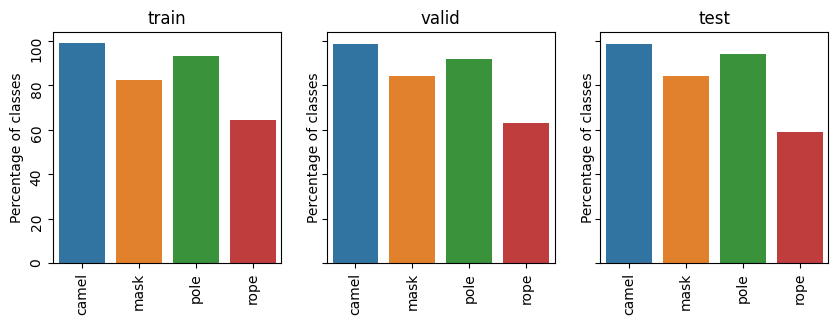

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(data=pd.DataFrame({mode: class_stat[mode]}).T / data_len[mode] * 100, ax=ax[i])
    ax[i].set_title(mode)
    ax[i].tick_params(rotation=90)
    ax[i].set_ylabel('Percentage of classes')

plt.show()


- There is imbalance in classes


- Overall class distribution between train, validation and test sets are similar, although validation and test sets have significantly lower percentage of `machinery` class

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check image sizes</b></h4>

In [30]:
for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:\n')
    img_size = 0
    for file in glob.glob(os.path.join(INPUT_DIR, mode, 'images', '*')):
        image = Image.open(file)
        if image.size != img_size:
            print(f'\t{image.size}')
            img_size = image.size


Image sizes in train set:

	(512, 512)
	(482, 482)
	(414, 414)
	(512, 512)
	(422, 422)
	(512, 512)
	(448, 448)
	(474, 474)
	(512, 512)
	(500, 500)
	(476, 476)
	(456, 456)
	(512, 512)
	(460, 460)
	(434, 434)
	(506, 506)
	(442, 442)
	(422, 422)
	(512, 512)
	(492, 492)
	(512, 512)
	(448, 448)
	(512, 512)
	(414, 414)
	(512, 512)
	(468, 468)
	(472, 472)
	(512, 512)
	(446, 446)
	(512, 512)
	(474, 474)
	(512, 512)
	(454, 454)
	(446, 446)
	(512, 512)
	(418, 418)
	(512, 512)
	(482, 482)
	(512, 512)
	(508, 508)
	(442, 442)
	(474, 474)
	(482, 482)
	(462, 462)
	(508, 508)
	(512, 512)
	(414, 414)
	(512, 512)
	(480, 480)
	(512, 512)
	(452, 452)
	(512, 512)
	(454, 454)
	(512, 512)
	(430, 430)
	(512, 512)
	(428, 428)
	(512, 512)
	(466, 466)
	(512, 512)
	(474, 474)
	(476, 476)
	(512, 512)
	(424, 424)
	(434, 434)
	(462, 462)
	(512, 512)
	(508, 508)
	(512, 512)
	(446, 446)
	(512, 512)
	(430, 430)
	(474, 474)
	(512, 512)
	(500, 500)
	(512, 512)
	(462, 462)
	(512, 512)
	(434, 434)
	(480, 480)
	(414, 414)


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Check dataset sizes</b></h4>

In [ ]:
from tqdm import tqdm
DATA_DIR = "/home/raza.imam/Documents/FRC/YOLOv8/datasets/Camel-object-detection-MAIN-2"

img_names = Path(DATA_DIR+'train/').glob('*')
plt.figure(figsize=(10,10))
pbar = tqdm(img_names, total=len(df))
for img_name in pbar:
    img = load_img(img_name.as_posix())
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.plot(hist)
plt.show()

<a id="train"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Train</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Arguments for training</b></h4>

- **task**: preform `detect`, `segment` or `classify`
- **imgsz**: define input image size
- **batch**: determine batch size
- **epochs**: define the number of training epochs. (Note: often, 3000+ are common here!)
- **data**: set the path to our yaml file
- **mode**: mode - `train`, `val` or `predict`
- **model**: model to use (could be pre-trained)
- **name**: result names

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Load model<b></h4>

- Load `pre-trained` YOLO-nano model 

In [32]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 11.3MB/s]



<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Train</b></h4>

In [33]:
model.train(data=os.path.join(WORK_DIR,'data.yaml'),
            task='detect',
            imgsz=512,
            epochs=25,
            batch=32,
            mode='train',
            name='yolov8n_v1_train')

Ultralytics YOLOv8.0.20 🚀 Python-3.8.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/home/raza.imam/Documents/FRC/YOLOv8/datasets/Camel-object-detection-MAIN-2/data.yaml, epochs=25, patience=50, batch=32, imgsz=512, save=True, cache=False, device=, workers=8, project=None, name=yolov8n_v1_train, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=t

<a id="test"></a>

<h2 style="padding: 12px 12px; background-color: #F5B041; font-family: Sans-Serif; color:black">
Test</h2>

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Select best model</b></h4>

In [34]:
model = YOLO('runs/detect/yolov8n_v1_train/weights/best.pt')

<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Make predicitons on test set</b></h4>

In [35]:
results = model.predict(source=os.path.join(INPUT_DIR, 'test', 'images'), save=True)

Ultralytics YOLOv8.0.20 🚀 Python-3.8.13 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
Results saved to runs/detect/predict


<h4 style="border-bottom: 3px solid #FAD7A0; padding: 12px 12px; font-family: Sans-Serif; color:black">
<b>Show prediction results</b></h4>